In [11]:
"""
Given a matrix of class-level acoustic measurements (by averaging constituent syllables)
- Calc the distance matrix
- Do this n times:
  + Permute the matrix by swapping measurements of class A with class B randomly
  + Calc and store the distance matrix

- Move from top to bottom, at each cut-off value: (M)
    - Calc the distance rankings (R)
      + Calc the distance rankings
      + Store the rankings
    - Calculate the range of values of the permuted rankings (Rs)
    - Test if (R) is statistically different from Rs, 
      + if so:
         + Move to the right cut, repeat (M)
         + Move to the left cut, repeat (M)
      + if not:
         + return
"""
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from koe.model_utils import get_or_error
from koe.models import Database
from koe.sequence_utils import get_sequences
from koe.storage_utils import get_sids_tids
from root.models import User
from koe.cluster_analysis_utils import SimpleNameMerger, NameMerger, get_syllable_labels
from koe.sequence_utils import songs_to_syl_seqs
from koe.sequence_utils import calc_class_ajacency, calc_class_dist_by_adjacency

from nltk import ngrams

from koe.models import Segment, AudioFile
from root.models import ExtraAttr, ExtraAttrValue
from collections import Counter

import os
from django.conf import settings
from koe.ts_utils import extract_tensor_metadata, write_metadata, bytes_to_ndarray, get_rawdata_from_binary
from koe.model_utils import natural_order
from scipy.cluster.hierarchy import cut_tree

import colorlover as cl
nCategoricalColours = 11

from PIL import Image

from koe.sequence_utils import calc_class_dist_by_syl_features
from scipy.stats import zscore
from koe.utils import triu2mat, mat2triu
from scipy.spatial.distance import pdist

from scipy.cluster.hierarchy import linkage
from koe.model_utils import natural_order

from scipy.cluster import hierarchy

from koe.feature_utils import pca_optimal
from koe.management.utils.matplotlib_utils import scatter_plot_with_highlighted_clusters, show_highlighed_cls_syllables, plot_dendrogram

In [4]:
def drop_useless_columns(mat):
    colmin = np.min(mat, axis=0)
    colmax = np.max(mat, axis=0)

    useful_col_ind = np.where(np.logical_not(np.isclose(colmin, colmax, atol=1e-04)))[0]
    mat = mat[:, useful_col_ind]
    return mat


database = get_or_error(Database, dict(name='Bellbird_TMI'))
annotator_name = 'wesley'
label_level = 'label'

sids, tids = get_sids_tids(database)
annotator = get_or_error(User, dict(username__iexact=annotator_name))

label_arr, syl_label_enum_arr = get_syllable_labels(annotator, label_level, sids)

enum2label = {enum: label for enum, label in enumerate(label_arr)}
sid2enumlabel = {sid: enum_label for sid, enum_label in zip_equal(sids, syl_label_enum_arr)}

# Get the original measurements of syllables:
ord_id = 24
ordination = Ordination.objects.get(id=ord_id)
bytes_path = ordination.dm.get_bytes_path()
bytes_path = os.path.join(settings.BASE_DIR, bytes_path)

sids_path = ordination.dm.get_sids_path()
sids_path = os.path.join(settings.BASE_DIR, sids_path)
sids = bytes_to_ndarray(sids_path, np.int32)
metadata, headers = extract_tensor_metadata(sids, annotator)

coordinates = get_rawdata_from_binary(bytes_path, len(sids))
coordinates = drop_useless_columns(coordinates)
coordinates = zscore(coordinates)
coordinates[np.where(np.isinf(coordinates))] = 0
coordinates[np.where(np.isnan(coordinates))] = 0

In [5]:
def aggregate_class_features(syl_label_enum_arr, nlabels, ftvalues, method=np.mean):
    classes_info = [[] for _ in range(nlabels)]
    for sidx, enum_label in enumerate(syl_label_enum_arr):
        classes_info[enum_label].append(sidx)

    n_features = ftvalues.shape[1]
    class_measures = np.zeros((nlabels, n_features))
    for class_idx in range(nlabels):
        this_class_ids = classes_info[class_idx]
        this_class_ftv = ftvalues[this_class_ids]
        class_measures[class_idx, :] = method(this_class_ftv, axis=0)
        
    return class_measures, classes_info


In [6]:
nlabels = len(label_arr)
class_measures, classes_info = aggregate_class_features(syl_label_enum_arr, nlabels, coordinates)

In [7]:
def calc_ranking(class_measures):
    class_dist = pdist(class_measures)
    sorted_dist = np.sort(class_dist)
    return sorted_dist

    
def plot_ranking(class_measures):
    sorted_dist = calc_ranking(class_measures)

    fig = plt.figure(figsize=(18,18))
    ax = fig.gca()
    ax.plot(sorted_dist)

In [8]:
def is_structural(measures, dist_triu):
    if len(dist_triu) < 3:
        return False
    original_rankings = np.sort(dist_triu)

    ntrials = 100
    rankings = np.ndarray((ntrials, original_rankings.shape[0]))
    for i in range(ntrials):
        new_class_measures = mutate_class_measures(measures)
        rankings[i, :] = calc_ranking(new_class_measures)

    # Trial_mean is an array of len(dist_triu) elements, so is trial_std and random_deviations
    trial_mean = np.mean(rankings, axis=0)
    trial_std = np.std(rankings, axis=0)
    random_deviations = np.abs(rankings - trial_mean)
    
    # mean_random_deviations is an array of ntrials elements
    mean_random_deviations = np.sum(random_deviations, axis=1)

    observed_deviation = np.sum(np.abs(original_rankings - trial_mean))
    
    # Tree is structural if the real rankings are totally outside the range of permuted rankings
    # that is, if it is less than min deviation or more than max deviation
    x1 = observed_deviation < mean_random_deviations.min() or observed_deviation > mean_random_deviations.max()
    
    # Tree is structural if the real rankings are different from a random draw from permuted rankings
    # that is, if there are less than x% (e.g. 5%) of random deviations larger than the observed deviation
    x2 = np.sum(mean_random_deviations > observed_deviation) / ntrials < 0.05
    
    # If x1 is true, x2 definitely is true
    # 
    
#     print('X1 = {}, x2 = {}'.format(x1, x2))
#     if (x1 != x2):
#         print('mean_random_deviations = {}, observed_deviation = {}'.format(mean_random_deviations, observed_deviation))
    
    return x2
    
#     return observed_deviation < mean_random_deviations.min() or observed_deviation > mean_random_deviations.max()
    

def cut_tree_get_leaves(tree, height):
    cluster = cut_tree(tree, height=height)
    leaves = []
    nleaves = cluster.max() + 1
    for i in range(nleaves):
        leaf_class_inds = np.where(cluster == i)[0]
        leaves.append(leaf_class_inds)
    return leaves



def recursive_simprof(global_measures, global_cls_inds, clusters):
#     print('Considering {} classes: {}'.format(len(global_cls_inds), global_cls_inds))
    if global_cls_inds.shape[0] < 3:
        print('global_cls_inds.shape = {}. Add {}'.format(global_cls_inds.shape, global_cls_inds))
        clusters.append(global_cls_inds)
        return

    local_measures = global_measures[global_cls_inds, :]
    local_to_global_inds = {l:g for l,g in enumerate(global_cls_inds)}
    
    dist_triu = pdist(local_measures)
    local_tree = linkage(dist_triu, method='complete')
    cutoff = local_tree[:, 2].max()
    
#     print('Cutoff = {}'.format(cutoff))

    if is_structural(local_measures, dist_triu):
        leaves = cut_tree_get_leaves(local_tree, cutoff)
#         print('Split tree: {}'.format(leaves))
        for leaf_class_inds in leaves:
            leaf_class_global_inds=np.array([local_to_global_inds[i] for i in leaf_class_inds])
            recursive_simprof(global_measures, leaf_class_global_inds, clusters)
    else:
        clusters.append(global_cls_inds)
        print('Not structural. Add {}'.format(global_cls_inds))

# recursive_simprof(class_measures, clusters={})




0.37572297496366935	2
0.4818277644685228	3
0.5528038500898002	4
0.6071315886567015	5
0.6535125222364214	6
0.6954485150795686	7
0.725602558468148	8
0.7517874923863779	9
0.7748878568155475	10
0.7968713198255596	11
0.8173600537510692	12
0.8350879007564519	13
0.8500206977679406	14
0.8622201890691468	15
0.8732975745400878	16
0.8834968952951204	17
0.8932244354614791	18
0.9011176696457115	19
0.9083336733635644	20
0.9153493380417727	21
0.921307412466878	22
0.927134221307168	23
0.9322652672728907	24
0.9372712052494803	25
0.9413038389336221	26
0.9453465387503825	27
0.9489469377731697	28
0.9522945215583326	29
0.955216171528871	30
0.9580951919740449	31
0.9606357986718823	32
0.9630553390606974	33
0.965448673689578	34
0.9677190972098546	35
0.9697202078074473	36
0.9715818499756419	37
explained = 0.9715818499756419, data.shape= (96, 37)


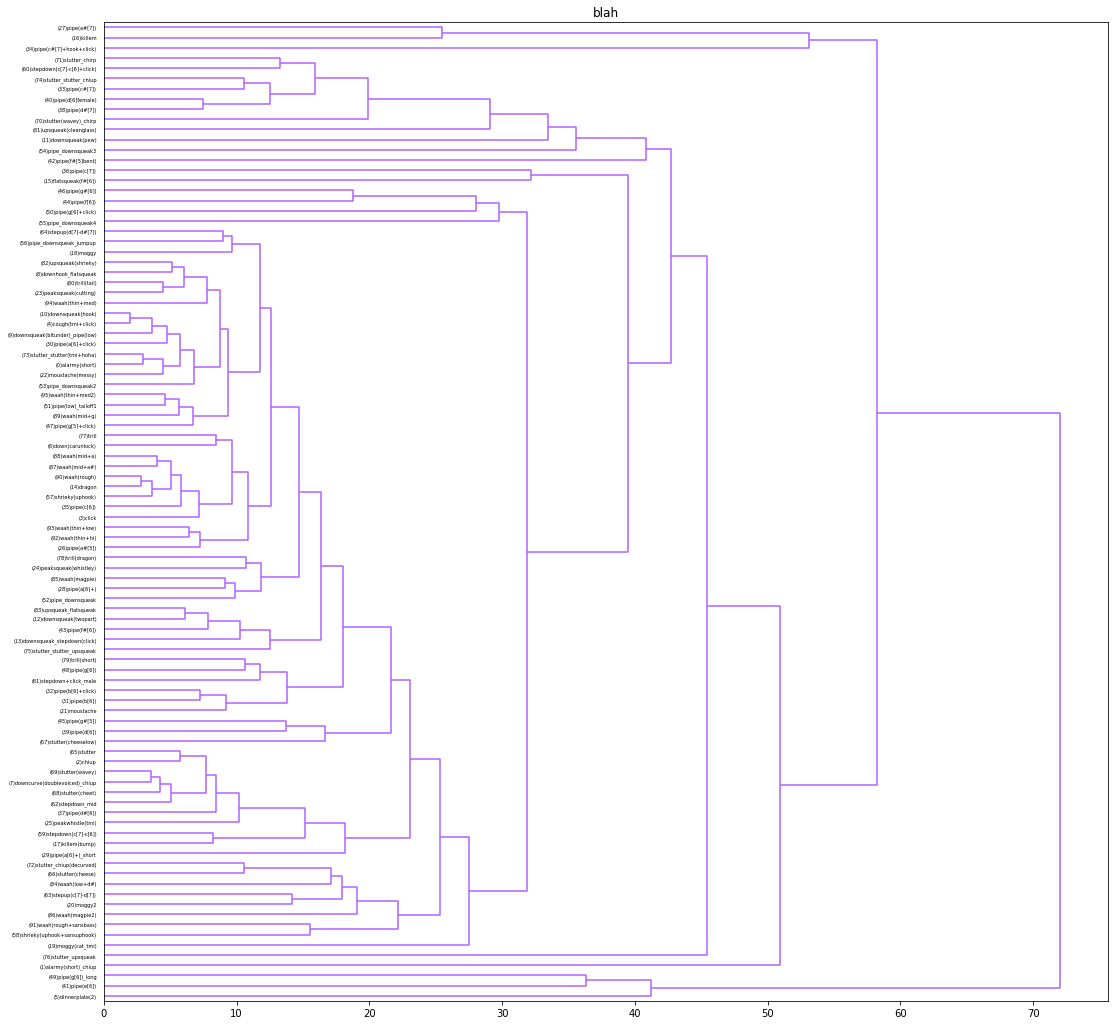

In [12]:
explained, class_measures_pcaed = pca_optimal(class_measures, 300, 0.97)
print('explained = {}, data.shape= {}'.format(explained, class_measures_pcaed.shape))

dist_triu = pdist(class_measures_pcaed)
tree = linkage(dist_triu, method='complete')
label_arr_enum = ['({}){}'.format(i, label) for i, label in enumerate(label_arr)]
plot_dendrogram(tree, 'blah', label_arr=label_arr_enum)


In [15]:
from abc import abstractmethod
class Permuter(object):
    @abstractmethod
    def __init__(self, *args):
        self.iterable_cols = None

    def permute(self, class_measures):
        nclasses, nfeatures = class_measures.shape
        # for each feature (each column), randomly swap the measurements between classes
        # We do this by copying the data from the source column to another column using a random mapping
        # e.g. destination[:, feature_index] = source[random_column_idx, feature_index]
        new_class_measures = np.ndarray((nclasses, nfeatures), dtype=class_measures.dtype)

        for feature_index in self.iterable_cols:
            random_row_inds = np.arange(nclasses)
            np.random.shuffle(random_row_inds)

            new_class_measures[:, feature_index] = class_measures[random_row_inds, :][:, feature_index]
        return new_class_measures


class PcaPermuter(Permuter):
    def __init__(self, nfeatures, *args):
        super(PcaPermuter, self).__init__(*args)
        self.iterable_cols = range(nfeatures)

def is_structural(measures, dist_triu, permuter, significance, ntrials):
    if len(dist_triu) < 3:
        return False
    original_rankings = np.sort(dist_triu)
    rankings = np.ndarray((ntrials, original_rankings.shape[0]))
    for i in range(ntrials):
        new_class_measures = permuter.permute(measures)
        rankings[i, :] = calc_ranking(new_class_measures)

    # Trial_mean is an array of len(dist_triu) elements, so is trial_std and random_deviations
    trial_mean = np.mean(rankings, axis=0)
    random_deviations = np.abs(rankings - trial_mean)

    # mean_random_deviations is an array of ntrials elements
    mean_random_deviations = np.sum(random_deviations, axis=1)

    observed_deviation = np.sum(np.abs(original_rankings - trial_mean))

    # Tree is structural if the real rankings are different from a random draw from permuted rankings
    # that is, if there are less than x% (e.g. 5%) of random deviations larger than the observed deviation
    return np.sum(mean_random_deviations > observed_deviation) / ntrials < significance


def cut_tree_get_leaves(tree, height):
    cluster = cut_tree(tree, height=height)
    leaves = []
    nleaves = cluster.max() + 1
    for i in range(nleaves):
        leaf_class_inds = np.where(cluster == i)[0]
        leaves.append(leaf_class_inds)
    return leaves


def recursive_simprof(global_measures, permuter, global_cls_inds, clusters, significance=0.05, ntrials=100):
    print('Considering {} classes: {}'.format(len(global_cls_inds), global_cls_inds))
    if global_cls_inds.shape[0] < 3:
        print('global_cls_inds.shape = {}. Add {}'.format(global_cls_inds.shape, global_cls_inds))
        clusters.append(global_cls_inds)
        return

    local_measures = global_measures[global_cls_inds, :]
    local_to_global_inds = {l: g for l, g in enumerate(global_cls_inds)}

    dist_triu = pdist(local_measures)
    local_tree = linkage(dist_triu, method='complete')
    cutoff = local_tree[:, 2].max()

    if is_structural(local_measures, dist_triu, permuter, significance, ntrials):
        leaves = cut_tree_get_leaves(local_tree, cutoff)
        # print('Split tree: {}'.format(leaves))
        for leaf_class_inds in leaves:
            leaf_class_global_inds = np.array([local_to_global_inds[i] for i in leaf_class_inds])
            recursive_simprof(global_measures, permuter, leaf_class_global_inds, clusters, significance, ntrials)
    else:
        clusters.append(global_cls_inds)
        print('Not structural. Add {}'.format(global_cls_inds))


In [111]:
inital_inds = np.arange(nlabels)
clusters = []
nclasses, nfeatures = class_measures_pcaed.shape
permuter = PcaPermuter(nfeatures)
recursive_simprof(class_measures_pcaed, permuter, inital_inds, clusters, significance=0.05)

Considering 96 classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Considering 93 classes: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47 48 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Considering 90 classes: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 28 29 30 31 32 33 35 36 37 38 39 40 42 43 44 45 46 47 48 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Considering 89 classes: [ 0  2  3  4  6  7  8  9 10 11 12 13 14 15 17 18 19 

In [24]:
def plot_dendrogram(tree, figname, label_arr, color_threshold=None, pdf=None, fig=None):
    import matplotlib.pyplot as plt
    if fig is None:
        fig = plt.figure(figsize=(18, 18))
    ax = fig.gca()
    ax.set_title(figname)
    def link_color_func(x):
        print(x)
        return '#B061FF'
    # First define the leaf label function.
    def llf(id):
        print(id)
        return str(id)

    hierarchy.dendrogram(
        tree,
        labels=label_arr,
        orientation='right',
        color_threshold=color_threshold,
        leaf_label_func=llf,
        link_color_func=link_color_func
    )
    if pdf:
        pdf.savefig(fig)
        plt.close()
    else:
        plt.show()




# # for cluster in clusters:
# #     print(label_arr[np.array(cluster)])

# ord_bytes_path = ordination.get_bytes_path()
# ord_bytes_path = os.path.join(settings.BASE_DIR, ord_bytes_path)

# ord_sids_path = ordination.get_sids_path()
# ord_sids_path = os.path.join(settings.BASE_DIR, ord_sids_path)
# sids = bytes_to_ndarray(sids_path, np.int32)
# metadata, headers = extract_tensor_metadata(sids, annotator)

# ord_coordinates = get_rawdata_from_binary(ord_bytes_path, len(sids))
# ord_coordinates = drop_useless_columns(ord_coordinates)
# ord_coordinates = zscore(ord_coordinates)
# ord_coordinates[np.where(np.isinf(ord_coordinates))] = 0
# ord_coordinates[np.where(np.isnan(ord_coordinates))] = 0

# label_colid = np.where(np.array(headers)==label_level)[0][0]
# tid_colid = np.where(np.array(headers)=='tid')[0][0]
# label_col = np.array([metadata[sid][label_colid] for sid in sids])
# tid_col = np.array([metadata[sid][tid_colid] for sid in sids])

# pdf = PdfPages('symprof.pdf')
# for cluster in clusters:
#     highlighted_cls_names = label_arr[np.array(cluster)]
#     if len(highlighted_cls_names) == 1:
#         continue
#     scatter_plot_with_highlighted_clusters(highlighted_cls_names, label_col, sids, ord_coordinates, pdf=pdf)
#     show_highlighed_cls_syllables(highlighted_cls_names, label_col, tid_col, pdf=pdf)
# pdf.close()

5
41
49
181
184
1
76
19
58
91
157
86
20
63
154
84
66
72
140
161
162
166
169
29
17
59
127
25
37
62
68
7
69
99
103
108
2
65
113
124
128
138
156
164
67
39
45
152
160
21
31
32
122
133
61
48
79
142
145
153
75
13
43
12
83
116
126
139
149
52
28
85
132
137
24
78
143
147
26
92
93
117
121
3
35
57
14
90
97
101
87
88
102
109
114
120
6
77
129
135
144
47
89
51
95
106
111
118
53
22
0
73
98
104
30
9
4
10
96
100
107
112
119
94
23
80
105
8
82
110
115
125
130
134
18
56
64
131
136
146
150
155
159
163
168
170
171
173
55
50
44
46
165
174
176
177
15
36
178
182
42
54
11
81
70
38
40
123
33
74
141
148
60
71
151
158
167
175
179
180
183
185
186
187
34
16
27
172
188
189
190


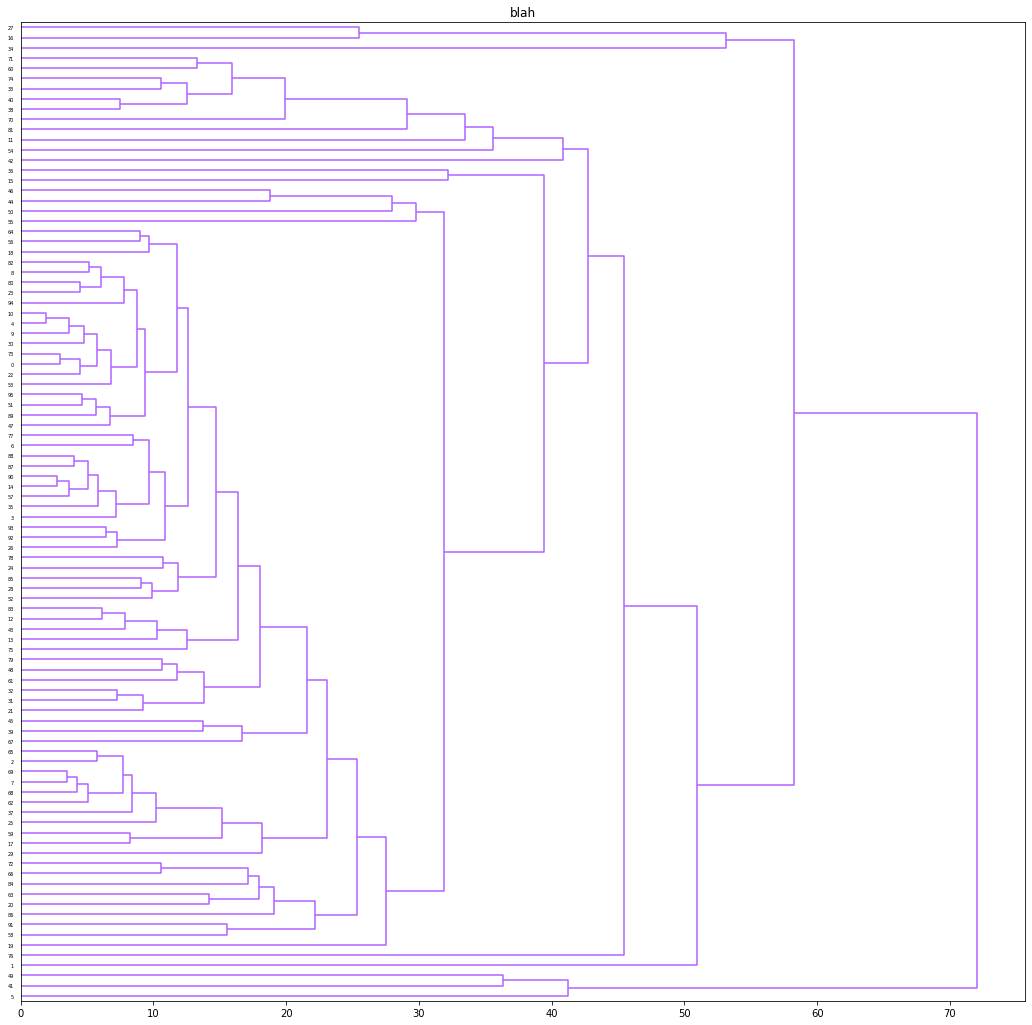

In [25]:
plot_dendrogram(tree, 'blah', label_arr=label_arr_enum)

/Users/yfukuzaw/workspace/koe/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


10
11
12
13
15
14
16
17
18


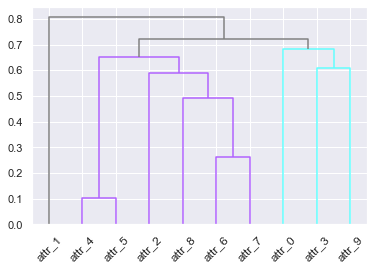

In [32]:
# Init
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Load data
from sklearn.datasets import load_diabetes

# Clustering
from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list
from scipy.spatial import distance

%matplotlib inline

# Dataset
A_data = load_diabetes().data
DF_diabetes = pd.DataFrame(A_data, columns = ["attr_%d" % j for j in range(A_data.shape[1])])

# Absolute value of correlation matrix, then subtract from 1 for disimilarity
DF_dism = 1 - np.abs(DF_diabetes.corr())

# Compute average linkage
A_dist = distance.squareform(DF_dism.as_matrix())
Z = linkage(A_dist,method="average")

# see question for code prior to "color mapping"

# Color mapping
dflt_col = "#808080"   # Unclustered gray
D_leaf_colors = {"attr_1": dflt_col,

                 "attr_4": "#B061FF", # Cluster 1 indigo
                 "attr_5": "#B061FF",
                 "attr_2": "#B061FF",
                 "attr_8": "#B061FF",
                 "attr_6": "#B061FF",
                 "attr_7": "#B061FF",

                 "attr_0": "#61ffff", # Cluster 2 cyan
                 "attr_3": "#61ffff",
                 "attr_9": "#61ffff",
                 }

# notes:
# * rows in Z correspond to "inverted U" links that connect clusters
# * rows are ordered by increasing distance
# * if the colors of the connected clusters match, use that color for link
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else D_leaf_colors["attr_%d"%x] for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col

def link_color_func(x):
    print(x);
    return link_cols[x]
    
# Dendrogram
D = dendrogram(Z=Z, labels=DF_dism.index, color_threshold=None,
  leaf_font_size=12, leaf_rotation=45, link_color_func=link_color_func)



In [39]:
Z[:,:2]

array([[ 4.,  5.],
       [ 6.,  7.],
       [ 8., 11.],
       [ 2., 12.],
       [ 3.,  9.],
       [10., 13.],
       [ 0., 14.],
       [15., 16.],
       [ 1., 17.]])

In [37]:
link_cols

{10: '#B061FF',
 11: '#B061FF',
 12: '#B061FF',
 13: '#B061FF',
 14: '#61ffff',
 15: '#B061FF',
 16: '#61ffff',
 17: '#808080',
 18: '#808080'}

In [56]:
X = np.array(
    [[5,3], #0 
    [10,15],#1
    [15,12],#2
    [24,10],#3
    [30,30],#4
    [85,70],#5
    [71,80],#6
    [60,78],#7
    [70,55],#8
    [80,91],])
X_names = ['5:3', '10:15', '15:12', '24:10', '30:30', '85:70', '71:80', '60:78', '70:55', '80:91']
clusters = [
    [1,2,3],
    [6,7],
    [5,8]
]
cluster_map = {}
for cind, c in enumerate(clusters):
    for ind in c:
        cluster_map[ind] = cind
colours = [
    '#FF0000', '#00FF00', '#0000FF'
]
Z = linkage(X, 'average')


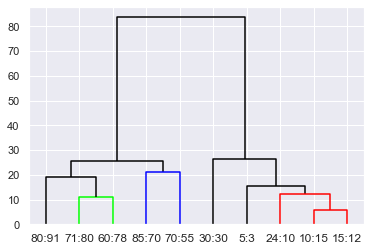

In [84]:
D = dendrogram(Z=Z, labels=X_names, leaf_label_func=llf, link_color_func=link_color_func)

In [83]:
link_cols

{10: '#FF0000',
 11: '#00FF00',
 12: '#FF0000',
 13: '#000000',
 14: '#000000',
 15: '#0000FF',
 16: '#000000',
 17: '#000000',
 18: '#000000'}

In [184]:
import colorlover as cl

n_categorical_colours = 11
    
def to_hex( scale ):
    ''' convert an hsl, numeric or rgb color to string hex color. ie,
        [ "hsl(360,100,100)", "hsl(360,100,100)", "hsl(360,100,100)" ] -->
        [ "#FFFFFF", "#FFFFFF", "#FFFFFF" ]
        '''
    s_t = cl.scale_type(scale)

    if s_t == 'hex':
        return scale
    elif s_t == 'numeric':
        return ['#%02x%02x%02x' % tuple(map(int, s)) for s in cl.to_numeric( scale )]
    elif s_t == 'rgb':
        return ['#%02x%02x%02x' % tuple(map(int, s)) for s in cl.to_numeric( scale )]
    elif s_t == 'hsl':
        return ['#%02x%02x%02x' % tuple(map(int, s)) for s in cl.to_numeric(scale)]

def get_colours(n_classes, rettype='numeric255'):
    if n_classes <= n_categorical_colours:
        #     colours = cl.to_numeric(cl.scales[str(nClasses)]['div']['Spectral'])
        colours = cl.to_numeric(cl.scales[str(n_classes)]['div']['Spectral'])
    else:
        colours = cl.to_numeric(cl.interp(cl.scales[str(n_categorical_colours)]['div']['Spectral'], n_classes))
    if rettype == 'numeric255':
        return colours
    if rettype == 'numeric1':
        return (np.array(colours) / 255.).tolist()
    if rettype == 'hex':
        print(colours)
        return to_hex(colours)
    
    raise Exception('Unknown type {}'.format(rettype))
    
def plot_dendrogram(tree, figname, label_arr, clusters=None, pdf=None, fig=None):
    import matplotlib.pyplot as plt
    if fig is None:
        fig = plt.figure(figsize=(18, 18))
    ax = fig.gca()
    ax.set_title(figname)
    
    nleaves = len(tree)
    
    if clusters is None:
        link_color_func = None
    else:
        clusters = [x for x in clusters if len(x) > 1]
        nclusters = max(len(clusters), 3)
        cluster_map = {}
        for cind, c in enumerate(clusters):
            for ind in c:
                cluster_map[ind] = cind

        colours = get_colours(nclusters, 'hex')
        link_cols = {}
        for i, i12 in enumerate(tree[:,:2].astype(int)):
            cs = []
            for x in i12:
                if x > nleaves:
                    c = link_cols[x]
                else:
                    if x in cluster_map:
                        c = colours[cluster_map[x]]
                    else:
                        c = '#000000'
                cs.append(c)
            link_cols[i+1+nleaves] = cs[0] if cs[0] == cs[1] else '#000000'

        link_color_func = lambda x: link_cols[x]

    hierarchy.dendrogram(
        tree,
        labels=label_arr,
        orientation='right',
        link_color_func=link_color_func
    )
    if pdf:
        pdf.savefig(fig)
        plt.close()
    else:
        plt.show()


ValueError: could not convert string to float: '98.0%'

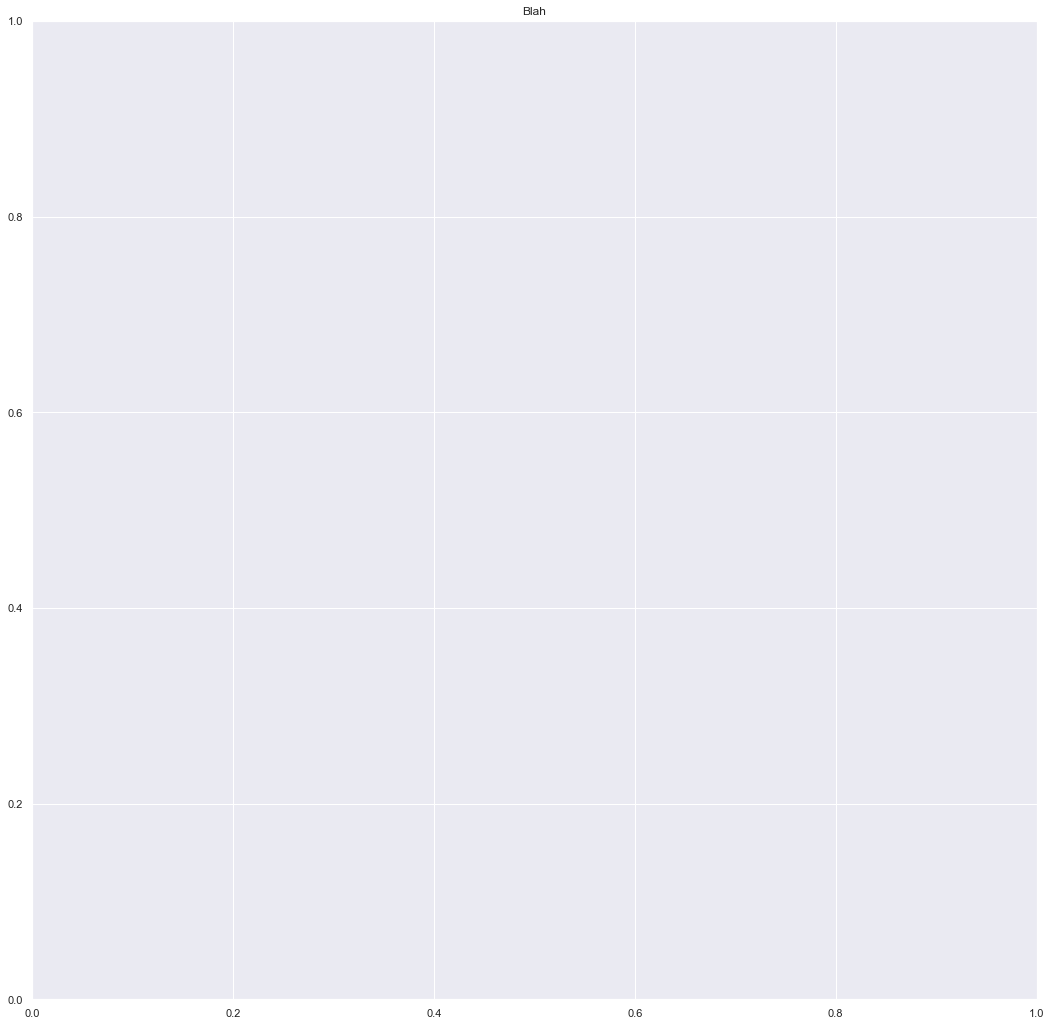

In [162]:
plot_dendrogram(tree, 'Blah', label_arr_enum, clusters[:20])

In [156]:
clusters

[array([ 0, 73]),
 array([22]),
 array([ 4, 10]),
 array([9]),
 array([30]),
 array([53]),
 array([ 8, 23, 80, 82, 94]),
 array([47, 51, 89, 95]),
 array([18, 56, 64]),
 array([3]),
 array([14, 57, 87, 88, 90]),
 array([35]),
 array([ 6, 77]),
 array([26, 92, 93]),
 array([24, 28, 52, 78, 85]),
 array([12, 43, 83]),
 array([13]),
 array([75]),
 array([21, 31, 32]),
 array([48, 61, 79]),
 array([39, 45, 67]),
 array([ 2, 65]),
 array([ 7, 62, 68, 69]),
 array([37]),
 array([25]),
 array([17, 59]),
 array([29]),
 array([20, 58, 63, 66, 72, 84, 86, 91]),
 array([19]),
 array([44, 46, 50, 55]),
 array([15, 36]),
 array([11]),
 array([33, 38, 40, 74]),
 array([60, 71]),
 array([70]),
 array([81]),
 array([54]),
 array([42]),
 array([76]),
 array([1]),
 array([16, 27, 34]),
 array([ 5, 41, 49])]

In [170]:
from colorlover import *
interp( cl.scales['11']['qual']['Paired'], 5000 )

['hsl(200.0, 52.0%, 77.0%)',
 'hsl(200.00800160032006, 52.036007201440285%, 76.92798559711943%)',
 'hsl(200.0160032006401, 52.072014402880576%, 76.85597119423885%)',
 'hsl(200.0240048009602, 52.10802160432086%, 76.78395679135828%)',
 'hsl(200.03200640128026, 52.14402880576115%, 76.7119423884777%)',
 'hsl(200.0400080016003, 52.18003600720144%, 76.63992798559713%)',
 'hsl(200.04800960192037, 52.21604320864173%, 76.56791358271654%)',
 'hsl(200.05601120224046, 52.25205041008201%, 76.49589917983597%)',
 'hsl(200.0640128025605, 52.288057611522305%, 76.42388477695539%)',
 'hsl(200.07201440288057, 52.32406481296259%, 76.35187037407482%)',
 'hsl(200.08001600320063, 52.36007201440288%, 76.27985597119424%)',
 'hsl(200.0880176035207, 52.396079215843166%, 76.20784156831367%)',
 'hsl(200.09601920384077, 52.43208641728346%, 76.13582716543308%)',
 'hsl(200.10402080416083, 52.46809361872374%, 76.06381276255252%)',
 'hsl(200.11202240448088, 52.504100820164034%, 75.99179835967193%)',
 'hsl(200.1200240048

In [172]:
import colorsys

colorsys.rgb_to_hls(0.2,1,1)

(0.5, 0.6, 1.0)

Considering 11 classes: [ 0  1  2  3  4  5  6  7  8  9 10]
Considering 6 classes: [0 1 2 3 4 5]
Considering 5 classes: [0 1 2 3 4]
Not structural. Add [0 1 2 3 4]
Considering 1 classes: [5]
global_cls_inds.shape = (1,). Add [5]
Considering 5 classes: [ 6  7  8  9 10]
Not structural. Add [ 6  7  8  9 10]
[(252.0, 141.0, 89.0), (255.0, 255.0, 191.0), (153.0, 213.0, 148.0)]


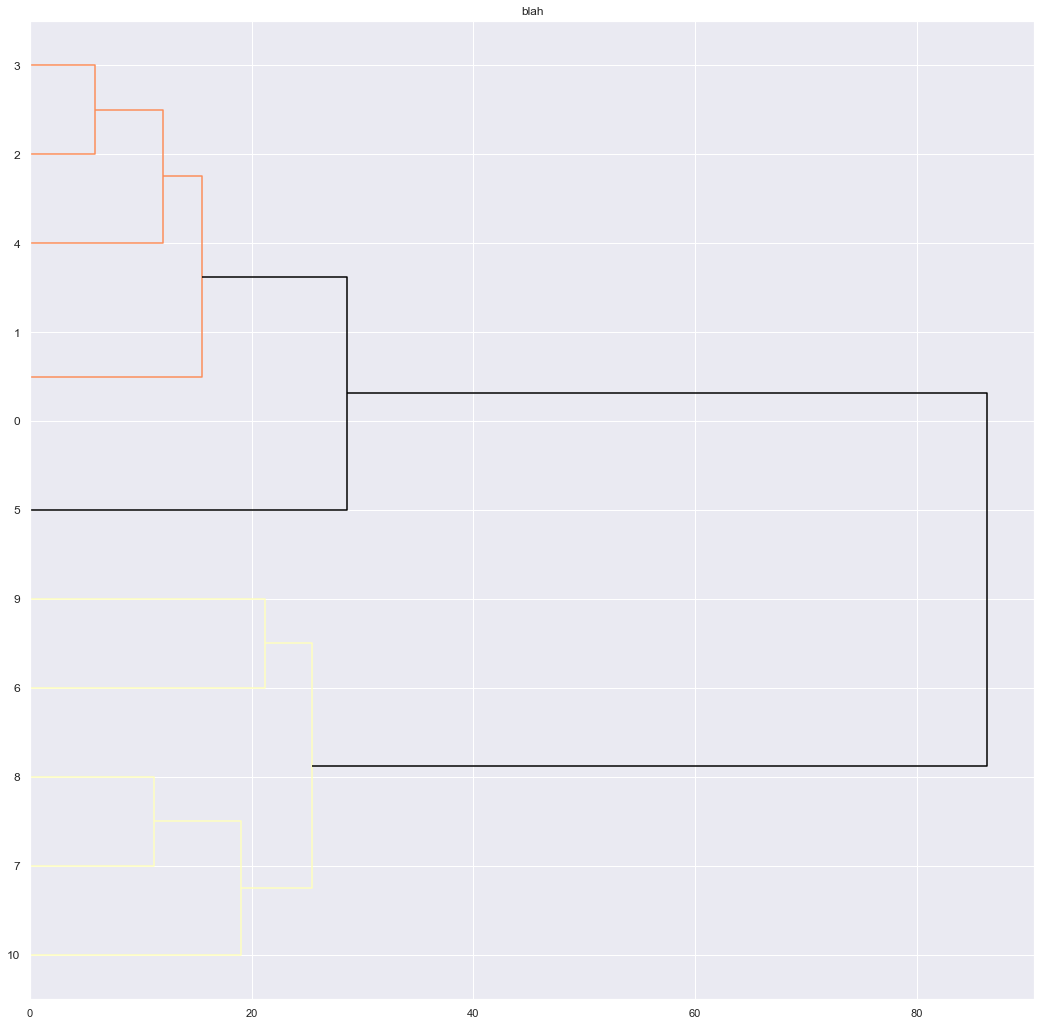

In [196]:
X = np.array([
    [5,3],  
#     [5,3.01],  
#     [5.01,3],
#     [5.02,3.01],  
#     [4.98,3.02],  
    [5,3.03],  
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],
])
Z = linkage(X,method="average")
nclasses, nfeatures = X.shape
permuter = PcaPermuter(nfeatures)
clusters = []
recursive_simprof(X, permuter, np.arange(len(X)), clusters)
plot_dendrogram(Z, 'blah', np.arange(len(X)), clusters)

In [191]:
Z

array([[0. , 1. , 0. , 2. ],
       [2. , 3. , 0.1, 3. ]])